## Installing all the necessary Packages

In [1]:
!pip install --upgrade pip

In [2]:
# First upgrade the environment.
from subprocess import run
# Add & Upgrade whatever you will need
modules =[
    'yfinance',    # Required for Yahoo Finance model
    'fredapi',     # Required to access FRED Data for MacroEconomics indices
    'ta'           # Required for the MACD indicator
]
proc = run(f'pip install {" ".join(modules)} --upgrade --no-input', 
       shell=True, 
       text=True, 
       capture_output=True, 
       timeout=120) #a couple of minutes
print(proc.stderr)

In [3]:
# Text Formating {Fore Colors and Background Colors definition}
RESET = '\033[0m'
BOLD  = '\033[1m'
ITALIC= "\033[3m"
ULINE = '\033[4m'
BLINK = "\033[5m"
NEGATIVE = "\033[7m"

RED   = '\033[31m'
GREEN = '\033[32m'
YELLOW= '\033[33m'
BLUE  = '\033[34m'
PURPLE= '\033[35m'
CYAN  = '\033[36m'
WHITE = '\033[97m'

BgGREEN = '\033[42m'
BgYELLOW= '\033[43m'
BgBLUE  = '\033[44m'
BgWHITE = '\033[47m'

## Import All the General and commonly used Packages

In [4]:
# Import all the common modules
import os
import warnings
import requests
import numpy as np
import pandas as pd
import yfinance as yf
from fredapi import Fred
from ta.trend import MACD
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler            #, StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Defining the reqired funtions

In [5]:
def Calculate_RSI(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [6]:
def Calculate_EMA(data, n):
    ema_values = [data[0]]  # Initialize EMA list with the first value
    smoothing_factor = 2 / (n + 1)
    
    for i in range(1, len(data)):
        ema = (data[i] * smoothing_factor) + (ema_values[i - 1] * (1 - smoothing_factor))
        ema_values.append(ema)
    
    return ema_values

In [7]:
# Calculate On Balance Volume (OBV)
def Get_Obv(df):
    df['Daily Change'] = df['Price'].diff()
    df['Volume Direction'] = np.where(df['Daily Change'] >= 0, 1, -1)
    df['OBV'] = df['Volume Direction'] * df['Volume']
    df.fillna(0, inplace=True)
    df['OBV'] = df['OBV'].cumsum()
    df.drop(['Daily Change', 'Volume Direction'], axis=1, inplace=True)

In [8]:
def FillGaps(StartingDate, EndingDate, StartVal, EndVal):
    import math

    # Generate business days for the year
    Business_Days = pd.date_range(start=StartingDate+timedelta(days=1, hours=0), end=EndingDate-timedelta(days=1, hours=0), freq='B')

    # Calculate the incremental value
    SVal = value = float(StartVal)
    EVal = value = float(EndVal)
    if (math.isnan(SVal)):
        Incremental_Value = 0
    elif ((not math.isnan(SVal)) & (math.isnan(EVal))):
        Incremental_Value = StartVal
    elif ((not math.isnan(SVal)) & (not math.isnan(EVal))):
        Incremental_Value = (EndVal - StartVal) / (len(Business_Days) + 1)

    return Incremental_Value

In [9]:
# Function to fetch MacroEconomics data from FRED
def Fetch_Series(APIKey, IndName, Series_ID):
    #StartDate = pd.to_datetime('1982.01.01')
    StartDate = MinDate
    EndDate = pd.Timestamp.today().normalize()
    Data_Dict = {}
    try:
        Data = APIKey.get_series(Series_ID, StartDate, EndDate)
        Data_Dict[IndName] = Data
        Df = pd.DataFrame(Data_Dict)
        Df.reset_index(inplace=True)
        Df.rename(columns={'index': 'Date'}, inplace=True)
        Df.sort_values(by=['Date'], ascending=[True], inplace=True)
        MaxDate = Df.Date.max()
        DfTmp = Df.copy()
        
        # MacroEconomic data is maintained on Monthly and Quarterly Bases.
        # The following code will fill the Daily gaps in the data with the calibrated incremental values.
        for row in range(0, len(Df)-1):
            StartDate = DfTmp.iloc[row, 0]
            StartVal = DfTmp.iloc[row, 1]
            EndDate = DfTmp.iloc[row+1, 0]
            EndVal = DfTmp.iloc[row+1, 1]
    
            IncVal = FillGaps(StartDate, EndDate, StartVal, EndVal)
            Business_Days = pd.date_range(start=StartDate+timedelta(days=1, hours=0), end=EndDate-timedelta(days=1, hours=0), freq='B')
            Val = StartVal
            for BDay in Business_Days:
                Val = Val + IncVal
                Df.loc[len(Df.index)] = [BDay, Val]
    
        if (MaxDate < pd.Timestamp.today().normalize()):
            StartDate = MaxDate
            EndDate = pd.Timestamp.today().normalize()
            Business_Days = pd.date_range(start=StartDate+timedelta(days=1, hours=0), end=EndDate-timedelta(days=0, hours=0), freq='B')
            Val = EndVal
            for BDay in Business_Days:
                Val = Val + IncVal
                Df.loc[len(Df.index)] = [BDay, Val]
    except Exception as e:
        print(f"Error fetching {IndName}: {e}")
    return Df

In [10]:
def TestTheModel(Model):
    # Checking how good this Model will be
    # Forecast day(s) ahead based on Test Data
    y_Train_Pred = Model.predict(X_train)
    y_Test_Pred = Model.predict(X_test)
    
    r2_Train = 0.00
    r2_Test = 0.00
    # Calculate R² error on Training Data and Test Data
    r2_Train = r2_score(y_train, y_Train_Pred)
    r2_Test = r2_score(y_test, y_Test_Pred)
    
    # Display results
    print(f"R² error on Training Data: {r2_Train:.5f}")
    print(f"R² error on Test Data: {r2_Test:.5f}")
    
    # Confirm that R² error on Training Data is better than R² error on Test Data
    if (r2_Train >= r2_Test) & ((1.00 - r2_Train) < 0.1) & ((r2_Train - r2_Test) < 0.2):
        if (r2_Test == 1.00):
            Comment = 'Excellent Model!'
            print(f'{BOLD+GREEN+BgWHITE}{Comment}{RESET}\n{BOLD+ITALIC+NEGATIVE+BgGREEN}R² error on Training Data equals R² error on Test Data.{RESET}')
        elif (r2_Train > r2_Test) & ((1.00 - r2_Train) < 0.0001) & ((r2_Train - r2_Test) < 0.001):
            Comment = 'Very Good Model!'
            print(f'{BOLD+GREEN+BgWHITE}{Comment}{RESET}\n{BOLD+ITALIC+NEGATIVE+BgGREEN}R² error on Training Data is better than R² error on Test Data.{RESET}')
        elif (r2_Train > r2_Test) & ((1.00 - r2_Train) < 0.001) & ((r2_Train - r2_Test) < 0.01):
            Comment = 'Good Model!'
            print(f'{BOLD+GREEN+BgWHITE}{Comment}{RESET}\n{BOLD+ITALIC+NEGATIVE+BgGREEN}R² error on Training Data is better than R² error on Test Data.{RESET}')
        else:
            Comment = 'Fairly Good Model.'
            print(f'{BOLD+BLUE+BgWHITE}{Comment}{RESET}\n{BOLD+ITALIC+NEGATIVE+BgBLUE}R² error on Training Data is better than R² error on Test Data.{RESET}')
    else:
        Comment = 'Bad Model.'
        print(f'{BOLD+RED+BLINK+BgYELLOW}{Comment}{RESET}')
    return r2_Train, r2_Test, Comment

In [11]:
def Plot_TrainTest(CrncyPair, Y_Train, Y_Test):
    # Plot Train and Test prices
    plt.figure(figsize=(10, 6))
    plt.plot(Y_Train.index, Y_Train.values, label='Training Data', color='blue')
    plt.plot(Y_Test.index, Y_Test.values, label='Test Data', color='orange')
    plt.title('The Train/Test data for ' + CrncyPair + ' Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

In [12]:
def Rpt_Evaluate_Plot(CrncyPair, Model_Name, Model_Code, R2_Train, R2_Test, Comment, Y_Train, Y_Test, Y_Pred, MaxDate, Future_Preds):
    # Evaluate the model
    mae = mean_absolute_error(Y_Test, Y_Pred)
    print("Mean Absolute Error: {:.5f}".format(mae))
    # ============================================
    mse = mean_squared_error(Y_Test, Y_Pred)
    print("Mean Squared Error: {:.5f}".format(mse))
    # ===================================================
    rmse = np.sqrt(mse)
    print('Root Mean Squared Error: {:.5f}'.format(rmse))
    # ============================================
    r2 = r2_score(Y_Test, Y_Pred)
    print("R-squared (R2) score: {:.5f}".format(r2))
    # ============================================
    print('Future Predictions', Future_Preds)

    # Plotting the graph
    Future_Dates = pd.date_range(start=MaxDate+timedelta(days=1), periods=len(Future_Preds), freq="B")

    # Plot Actual vs Predicted prices
    plt.figure(figsize=(12, 6))
    plt.plot(Future_Dates, ActualValues, label='Actual Data', color='green')
    plt.plot(Future_Dates, Future_Preds, label='Predicted Data', color='blue')
    plt.scatter(Future_Dates, ActualValues, s=10, color='red')
    plt.scatter(Future_Dates, Future_Preds, s=10, color='red')
    plt.title(Model_Name + ': Actual vs Predicted values for ' + CrncyPair + ' Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

    # Inserting Record into the DataFrame
    Models_Compare.loc[len(Models_Compare.index)] = [Model_Name, Model_Code, mae, mse, rmse, R2_Train, R2_Test, Comment]

## Load the Currency Pair into DataFrame

In [13]:
TDSData = []
Investing = []

# Suppress all warnings
warnings.filterwarnings("ignore")

# Today's Date
TDate = pd.Timestamp.today().normalize()

In [14]:
# Every Currency Pair is a combination of Major and Minor currency
CrncyPair = 'USDCAD'
Major = CrncyPair[0:3]
Minor = CrncyPair[3:]

In [15]:
%%time
# My GitHub Data path
MyGitHubURL = 'https://raw.githubusercontent.com/Akubue4U/PyProjects/main/MyBDAThesis/'

# DATA SOURCE 01 (Investing Data stored in GitHub)
# ================================================
# Reading data frame from csv file
DataFolder = 'InvestingData/'
Base_URL = MyGitHubURL + DataFolder
InvCrncyPair = Major +'_'+ Minor
InvFileName = InvCrncyPair + '_Historical_Data'

# Check if the URL exists and is accessible
SuccessCode = [200, 400]
response = requests.head(Base_URL, timeout=5)
try:
    #if response.status_code in SuccessCode:
    File_URL = f'{Base_URL}{InvFileName}.csv'
    InvestingData = pd.read_csv(File_URL)
    InvestingData.drop(InvestingData.columns[[6]], axis=1, inplace=True)
    InvestingData['Vol'] = InvestingData['Vol'].fillna(0)

    # Convert Date string column to Date type
    InvestingData['Date'] = pd.to_datetime(InvestingData['Date'], format='%m/%d/%Y')

    # Set column 'Date' as the index
    InvestingData.set_index('Date', inplace=True)

    # Re-Arrange the columns to allign with that from Source 02 below.
    # Using indexing notation
    InvestingData = InvestingData[['Open', 'High', 'Low', 'Price', 'Vol']]
    InvestingData.rename(columns={"Vol": "Volume"}, inplace=True)
    
    # Also sort the Data by Dates to allign with Source 02 below.
    InvestingData.sort_values(by=['Date'], ascending=[True], inplace=True)
    DataSource = InvestingData.copy()
    print("Data Source in use is Investing.Com")
except Exception as e:
    # DATA SOURCE 02 (Tick Data Suite (TDS) stored in GitHub)
    # ======================================================
    # Reading data frame from csv file
    DataFolder = 'TDS-Data/'
    Base_URL = MyGitHubURL + DataFolder
    Symbol = Major + Minor +'_'

    # Check if the URL exists and is accessible
    response = requests.head(Base_URL, timeout=5)
    try:
        #if response.status_code in SuccessCode:
        # List to store DataFrames
        Df_List = []

        # Reading over 7,903,117 M1 data from GitHub
        # Iterate through the years and read each .csv file into a DataFrame
        for Year in range(2003, 2025):
            File_URL = f'{Base_URL}{Symbol}{Year}.csv'
            Df = pd.read_csv(File_URL)

            Df_List.append(Df)

        # Concatenate all DataFrames into one
        CombinedDf = pd.concat(Df_List, ignore_index=True)
        # Merge Date string and Time string, and convert to DateTime type
        CombinedDf['DateTime'] = pd.to_datetime((CombinedDf['Date'] + " " + CombinedDf['Time']), format='%Y.%m.%d %H:%M:%S')
        CombinedDf.drop(columns={'Date', 'Time'}, inplace=True)    
        CombinedDf.set_index(CombinedDf['DateTime'], inplace=True)

        # Stage 02
        # Subsample data to one-day time steps, including weekends
        DataOpen = CombinedDf.Open.resample('1D').first()
        DataHigh = CombinedDf.High.resample('1D').max()
        DataLow = CombinedDf.Low.resample('1D').min()
        DataClose = CombinedDf.Close.resample('1D').last()
        DataVolume = round(CombinedDf.TickVol.resample('1D').sum(), 2)

        # Merge the Data on a common key, Date
        TDSData = pd.merge(DataOpen, DataHigh, how='left', on=['DateTime'])
        TDSData = pd.merge(TDSData, DataLow, how='left', on=['DateTime'])
        TDSData = pd.merge(TDSData, DataClose, how='left', on=['DateTime'])
        TDSData = pd.merge(TDSData, DataVolume, how='left', on=['DateTime'])

        # Rename the index column to Date
        TDSData.reset_index(inplace=True)
        TDSData.rename(columns={'DateTime': 'Date', 'Close': 'Price', 'TickVol': 'Volume'}, inplace=True)
        TDSData.set_index('Date', inplace=True)
        TDSData.dropna(inplace = True)

        #TDSData.drop(columns=['TickVol'], inplace=True)

        # Also sort the Data by Dates to allign with Source 02 below.
        TDSData.sort_values(by=['Date'], ascending=[True], inplace=True)
        DataSource = TDSData.copy()
        print("Data Source in use is TDS.")
    except Exception as e:
        print(f"Error accessing GitHub path [{Base_URL}]: \n{e}")
MinDate = DataSource.index.min()        

Data Source in use is Investing.Com
CPU times: user 55.5 ms, sys: 9.8 ms, total: 65.3 ms
Wall time: 518 ms


In [16]:
# Free the momory by deleting the DataFrames no longer needed
del TDSData
del Investing

In [17]:
DataSource.tail(7).sort_values(by=['Date'], ascending=[False])

,Open,High,Low,Price,Volume
Date,,,,,
2024-10-29,1.3889,1.3930,1.3876,1.3925,0.0
2024-10-28,1.3891,1.3908,1.3878,1.3889,0.0
2024-10-25,1.3854,1.3897,1.3835,1.3891,0.0
2024-10-24,1.3836,1.3868,1.3810,1.3854,0.0
2024-10-23,1.3818,1.3862,1.3813,1.3836,0.0
2024-10-22,1.3831,1.3838,1.3811,1.3816,0.0
2024-10-21,1.3801,1.3849,1.3797,1.3831,0.0


In [18]:
print(len(DataSource))

11116


#### Adding the Statistical Data to the DataSource

In [19]:
# Feature Engineering: Calculate rolling averages, momentum indicators, etc.
DataSource['SMA_20'] = DataSource['Price'].rolling(window=20).mean()
DataSource['SMA_50'] = DataSource['Price'].rolling(window=50).mean()
DataSource['RSI'] = Calculate_RSI(DataSource['Price'], window=14)
DataSource['EMA_12'] = Calculate_EMA(DataSource['Price'], 12)
DataSource['EMA_26'] = Calculate_EMA(DataSource['Price'], 26)
DataSource['MACD'] = MACD(DataSource['Price']).macd()

# Drop rows with missing values
DataSource.dropna(inplace=True)

In [20]:
print(len(DataSource))

11067


#### Get the MacroEconomics Data

In [21]:
# My FRED API key
MyAPIKey = Fred(api_key='fb871b8abb01c472840cdd407ffd8dca')

# This is the list of Indices we want to retrieve for USA and Canada
MacroEconomic_Series_USA = {
    'CPI': 'CPIAUCSL',  # Consumer Price Index (USA)
    'IntRate': 'FEDFUNDS',  # Federal Funds Rate (USA)
    'UnEmployRate': 'UNRATE',  # Unemployment Rate (USA)
    'Imports': 'IMP0004',  # Imports (USA)
    'Exports': 'EXP0004'  # Exports (USA)
}

MacroEconomic_Series_Canada = {
    'CPI': 'CANCPIALLMINMEI',  # Consumer Price Index (Canada)
    'IntRate': 'IR3TIB01CAM156N',  # Interest Rate (Canada)
    'UnEmployRate': 'LRUNTTTTCAM156S',  # Unemployment Rate (Canada)
    'Imports': 'XTIMVA01CAM667S',  # Imports (Canada)
    'Exports': 'XTEXVA01CAM667S'  # Exports (Canada)
}

In [22]:
%%time
# Get the MacroEconomics Data
# Fetch data for USA
USA_Data = []
for IndName, Series_ID in MacroEconomic_Series_USA.items():
    Data = Fetch_Series(MyAPIKey, IndName, Series_ID)
    if (len(USA_Data) ==  0):
        USA_Data = Data.copy()
    else:
        USA_Data = pd.merge(USA_Data, Data, on='Date')
USA_Data.rename(columns={"CPI": "USA_CPIs", "IntRate": "USA_IntRates", "UnEmployRate": "USA_UnEmployRates", "Imports": "USA_Imports", "Exports": "USA_Exports"}, inplace=True)
#USA_Data = USA_Data.drop_duplicates()


# Fetch data for Canada
Canada_Data = []
for IndName, Series_ID in MacroEconomic_Series_Canada.items():
    Data = Fetch_Series(MyAPIKey, IndName, Series_ID)
    if (len(Canada_Data) ==  0):
        Canada_Data = Data.copy()
    else:
        Canada_Data = pd.merge(Canada_Data, Data, on='Date')
Canada_Data.rename(columns={"CPI": "CAN_CPIs", "IntRate": "CAN_IntRates", "UnEmployRate": "CAN_UnEmployRates", "Imports": "CAN_Imports", "Exports": "CAN_Exports"}, inplace=True)
#Canada_Data = Canada_Data.drop_duplicates()

# Merge the MacroEconomic datasets on a common key, such as Date
MacroEcons = pd.merge(USA_Data, Canada_Data, on='Date')

# Free the memory.
#del USA_Data, Canada_Data

CPU times: user 1min 13s, sys: 94.3 ms, total: 1min 13s
Wall time: 1min 16s


#### Mering the MacroEconomics Data with the DataSource

In [23]:
%%time
# Merge the DataSource with the MacroEconomic dataset on a common key, such as Date
Complete_Data = pd.merge(DataSource, MacroEcons, how='left', on=['Date'])

# Set NaN to Zero, and column 'Date' as the index
Complete_Data.fillna(0, inplace=True)
Complete_Data.set_index('Date', inplace=True)

# Free the memory.
#del DataSource, MacroEcons

CPU times: user 4.53 ms, sys: 5.95 ms, total: 10.5 ms
Wall time: 9.67 ms


## The Models

In [24]:
# Write the Performance Metrics to a DataFrame for easy comparism.
# Define column names
Cols = ['ModelName', 'ModelCode', 'MAE', 'MSE', 'RMSE', 'R2_Train', 'R2_Test', 'Comment']

# Create DataFrame
Models_Compare = pd.DataFrame(columns = Cols)

In [25]:
# Model Common/Global parameters & Modules
# Here, I choose to use 85% of my data for Training and the remaing 15% for Testing.
TestPercent = 0.15
TrainPercent = 1.0 - TestPercent

# Predictions
PredDays = 5

#### Creating Label column for the Forecast

In [26]:
# Creating 'Label' column for the forecast
#pd.options.mode.chained_assignment = None 
Complete_Data['Label'] = Complete_Data['Price'].shift(-(PredDays))
Complete_Data.dropna(inplace=True)
MaxDate = Complete_Data.index.max()

ActualValues = Complete_Data['Label'][-(PredDays):].values

In [27]:
Complete_Data.tail(8).sort_values(by=['Date'], ascending=[False])

,Open,High,Low,Price,Volume,SMA_20,SMA_50,RSI,EMA_12,EMA_26,...,USA_IntRates,USA_UnEmployRates,USA_Imports,USA_Exports,CAN_CPIs,CAN_IntRates,CAN_UnEmployRates,CAN_Imports,CAN_Exports,Label
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-22,1.3831,1.3838,1.3811,1.3816,0.0,1.365655,1.360014,86.206897,1.374717,1.367961,...,4.625455,4.1,262461.735313,190248.204860,127.240148,3.71625,7.104348,4.806968e+10,4.436456e+10,1.3925
2024-10-21,1.3801,1.3849,1.3797,1.3831,0.0,1.363725,1.359790,89.559165,1.373465,1.366870,...,4.639091,4.1,262626.527525,190033.609136,127.250452,3.72500,7.095652,4.804902e+10,4.440272e+10,1.3889
2024-10-18,1.3794,1.3815,1.3782,1.3800,0.0,1.362270,1.359610,81.797235,1.371713,1.365571,...,4.652727,4.1,262791.319736,189819.013411,127.260757,3.73375,7.086957,4.802837e+10,4.444089e+10,1.3891
2024-10-17,1.3751,1.3801,1.3744,1.3794,0.0,1.361115,1.359468,82.045455,1.370207,1.364417,...,4.666364,4.1,262956.111947,189604.417686,127.271061,3.74250,7.078261,4.800772e+10,4.447905e+10,1.3854
2024-10-16,1.3774,1.3793,1.3747,1.3750,0.0,1.359935,1.359336,82.207207,1.368535,1.363218,...,4.680000,4.1,263120.904158,189389.821961,127.281365,3.75125,7.069565,4.798707e+10,4.451722e+10,1.3836
2024-10-15,1.3795,1.3838,1.3767,1.3774,0.0,1.359205,1.359352,83.143508,1.367360,1.362276,...,4.693636,4.1,263285.696369,189175.226236,127.291670,3.76000,7.060870,4.796642e+10,4.455538e+10,1.3816
2024-10-14,1.3759,1.3805,1.3755,1.3795,0.0,1.358320,1.359374,88.747346,1.365534,1.361066,...,4.707273,4.1,263450.488580,188960.630511,127.301974,3.76875,7.052174,4.794577e+10,4.459355e+10,1.3831
2024-10-11,1.3738,1.3783,1.3723,1.3762,0.0,1.357270,1.359430,70.255474,1.362995,1.359591,...,4.720909,4.1,263615.280791,188746.034786,127.312278,3.77750,7.043478,4.792512e+10,4.463171e+10,1.3800


#### Split the Data, Scale, and Plot Train/Test

In [28]:
#Split data into train/test (85/15 ratio) with caution for time series
Complete_Data.dropna(inplace=True)
Split_Position = int(len(Complete_Data) * TrainPercent)
Train_Data, Test_Data = Complete_Data.iloc[:Split_Position], Complete_Data.iloc[Split_Position:]

In [29]:
#Initialize the MinMaxScaler
Scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler only on the training data
Scaler.fit(Train_Data)

# Transform both the training and test data using the same scaler
Train_Data_Scaled = Scaler.transform(Train_Data)
Test_Data_Scaled = Scaler.transform(Test_Data)

In [30]:
# Convert the scaled data back into a DataFrame for easy inspection
Train_Data_Scaled_Df = pd.DataFrame(Train_Data_Scaled, index=Train_Data.index, columns=Train_Data.columns)
Test_Data_Scaled_Df = pd.DataFrame(Test_Data_Scaled, index=Test_Data.index, columns=Test_Data.columns)

# Handle missing values
Train_Data_Scaled_Df.dropna(inplace=True)
Test_Data_Scaled_Df.dropna(inplace=True)

In [31]:
# Match into Training and Testing data
X_train, y_train = Train_Data_Scaled_Df, Train_Data['Label']
X_test, y_test = Test_Data_Scaled_Df, Test_Data['Label']

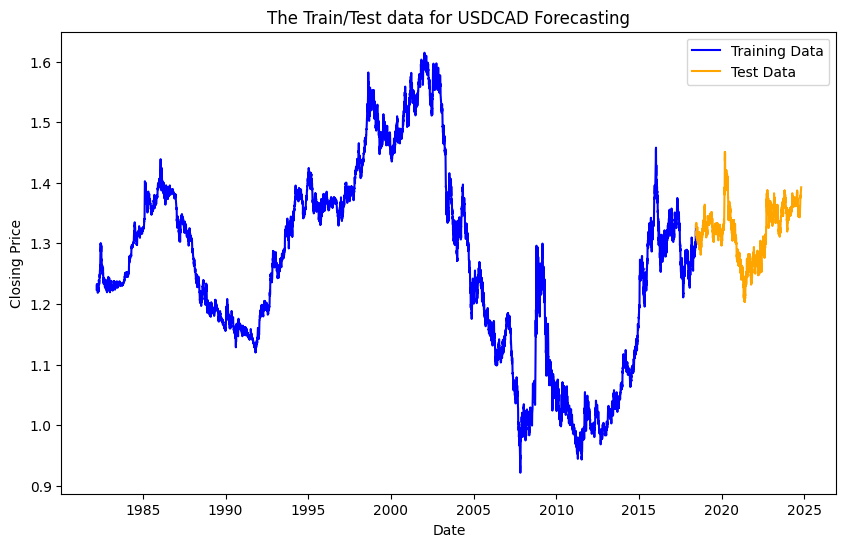

In [32]:
# Plotting the Train/Test Data
Plot_TrainTest(CrncyPair, y_train, y_test)

#### Linear Regression Model

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
# Instantiate Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

LinearRegression()

In [35]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(model)

R² error on Training Data: 1.00000
R² error on Test Data: 1.00000
Excellent Model!
R² error on Training Data equals R² error on Test Data.


Mean Absolute Error: 0.00000
Mean Squared Error: 0.00000
Root Mean Squared Error: 0.00000
R-squared (R2) score: 1.00000
Future Predictions [1.3836 1.3854 1.3891 1.3889 1.3925]


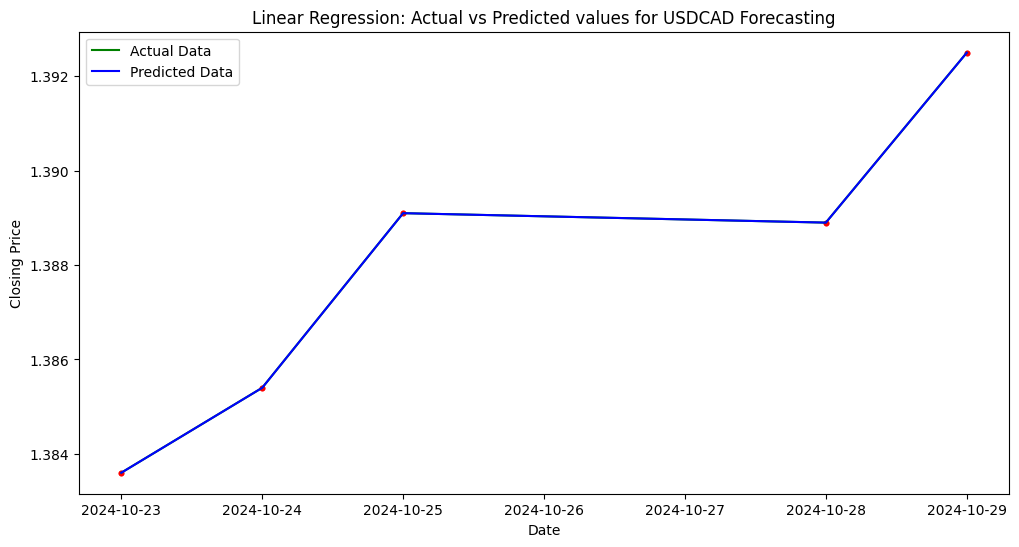

CPU times: user 268 ms, sys: 1.18 s, total: 1.45 s
Wall time: 198 ms


In [36]:
%%time
# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
LNR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'LNR'
ModelName = 'Linear Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### Random Forest Regressor Model

In [37]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingClassifier

In [38]:
# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=None)
model.fit(X_train, y_train)

RandomForestRegressor()

In [39]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment  = TestTheModel(model)

R² error on Training Data: 1.00000
R² error on Test Data: 1.00000
Very Good Model!
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.00004
Mean Squared Error: 0.00000
Root Mean Squared Error: 0.00007
R-squared (R2) score: 1.00000
Future Predictions [1.383563 1.385409 1.389105 1.388913 1.392558]


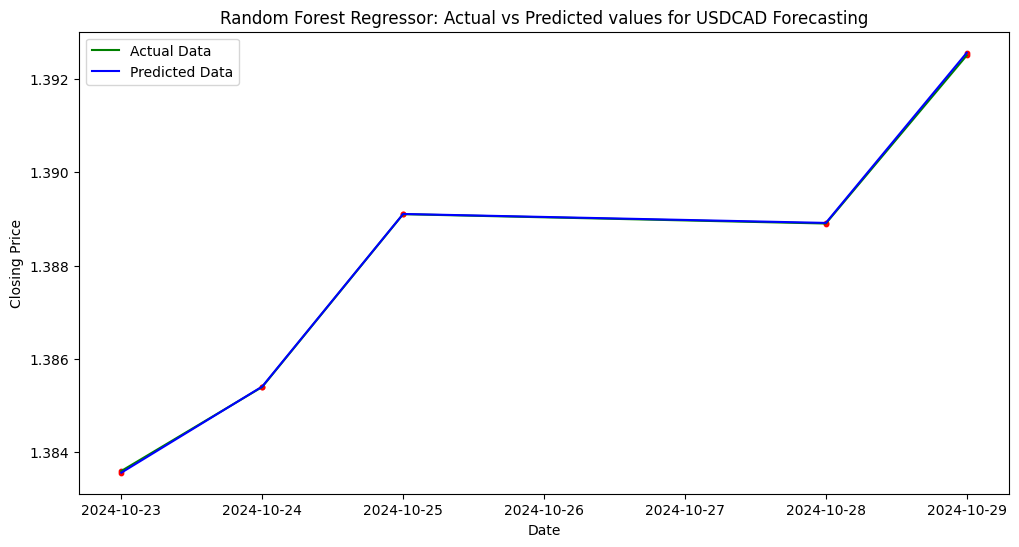

CPU times: user 180 ms, sys: 227 ms, total: 407 ms
Wall time: 164 ms


In [40]:
%%time
# Evaluate the model
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
RFR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'RFR'
ModelName = 'Random Forest Regressor'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### XGBoost Model

In [41]:
import xgboost as xgb

In [42]:
# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',   # Use squared error loss for regression
    'max_depth': 6,                    # Maximum depth of trees
    'learning_rate': 0.1,              # Learning rate {0.1}
    'n_estimators': 100,               # Number of boosting rounds (trees)
    'seed': 42                         # Random seed for reproducibility {42}
}

# Instantiate XGBoost regressor
xgb_model = xgb.XGBRegressor(**params)

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [43]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(xgb_model)

R² error on Training Data: 0.99998
R² error on Test Data: 0.99973
Very Good Model!
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.00054
Mean Squared Error: 0.00000
Root Mean Squared Error: 0.00071
R-squared (R2) score: 0.99973
Future Predictions [1.3831625 1.3849874 1.3891166 1.3888334 1.3927109]


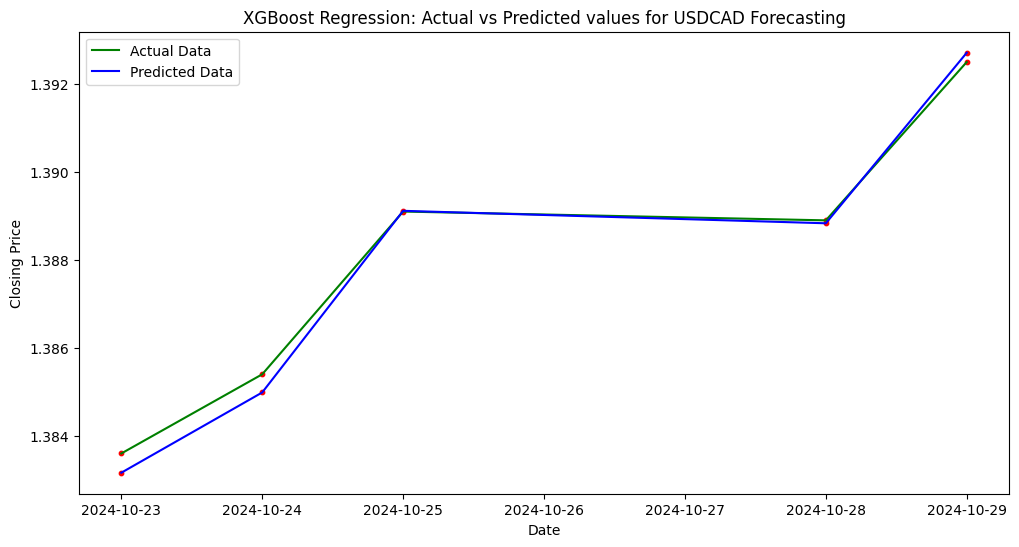

CPU times: user 239 ms, sys: 223 ms, total: 462 ms
Wall time: 138 ms


In [44]:
%%time
# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
XGB = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'XGB'
ModelName = 'XGBoost Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del xgb_model, y_pred, future_predictions

#### Ridge Regression Model

In [45]:
from sklearn.linear_model import Ridge

In [46]:
# Instantiate and fit the Ridge Regression model
alpha = 0.1  # Regularization strength (hyperparameter to be tuned)
model = Ridge(alpha=alpha)
model.fit(X_train, y_train)

Ridge(alpha=0.1)

In [47]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(model)

R² error on Training Data: 0.99999
R² error on Test Data: 0.99991
Very Good Model!
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.00033
Mean Squared Error: 0.00000
Root Mean Squared Error: 0.00042
R-squared (R2) score: 0.99991
Future Predictions [1.3836172  1.38545376 1.38907091 1.38898916 1.39243713]


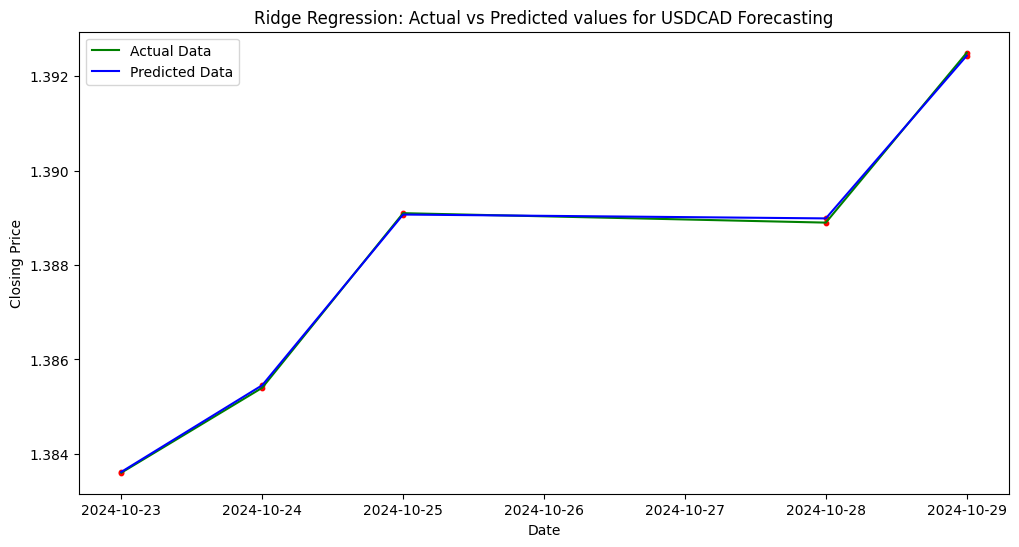

CPU times: user 252 ms, sys: 1.12 s, total: 1.37 s
Wall time: 175 ms


In [48]:
%%time
# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
RIR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'RIR'
ModelName = 'Ridge Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### Lasso Regression Model

In [49]:
from sklearn.linear_model import Lasso

In [50]:
# Instantiate and fit the Lasso Regression model
alpha = 0.1  # Regularization strength (hyperparameter to be tuned)
model = Lasso(alpha=alpha)
model.fit(X_train, y_train)

Lasso(alpha=0.1)

In [51]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(model)

R² error on Training Data: 0.00000
R² error on Test Data: -1.68518
Bad Model.


Mean Absolute Error: 0.06108
Mean Squared Error: 0.00503
Root Mean Squared Error: 0.07092
R-squared (R2) score: -1.68518
Future Predictions [1.26436986 1.26436986 1.26436986 1.26436986 1.26436986]


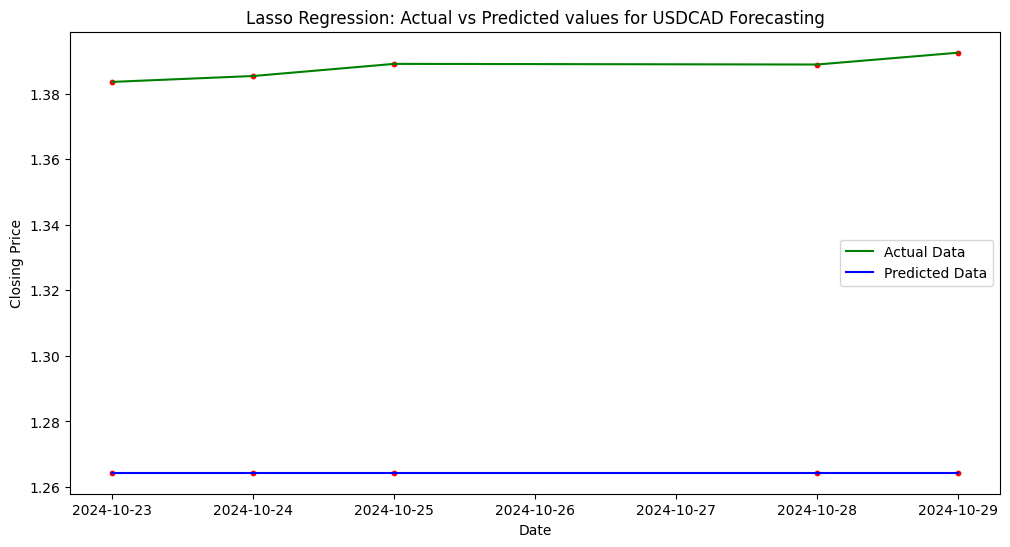

CPU times: user 372 ms, sys: 1.02 s, total: 1.39 s
Wall time: 287 ms


In [52]:
%%time
# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
LAR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'LAR'
ModelName = 'Lasso Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### Support Vector Regression (SVR) Model

In [53]:
from sklearn.svm import SVR

In [54]:
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr_model.fit(X_train, y_train)

SVR(epsilon=0.2)

In [55]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(svr_model)

R² error on Training Data: 0.68718
R² error on Test Data: -1.47620
Bad Model.


Mean Absolute Error: 0.06079
Mean Squared Error: 0.00464
Root Mean Squared Error: 0.06811
R-squared (R2) score: -1.47620
Future Predictions [1.26756296 1.26774351 1.268082   1.26853129 1.26864923]


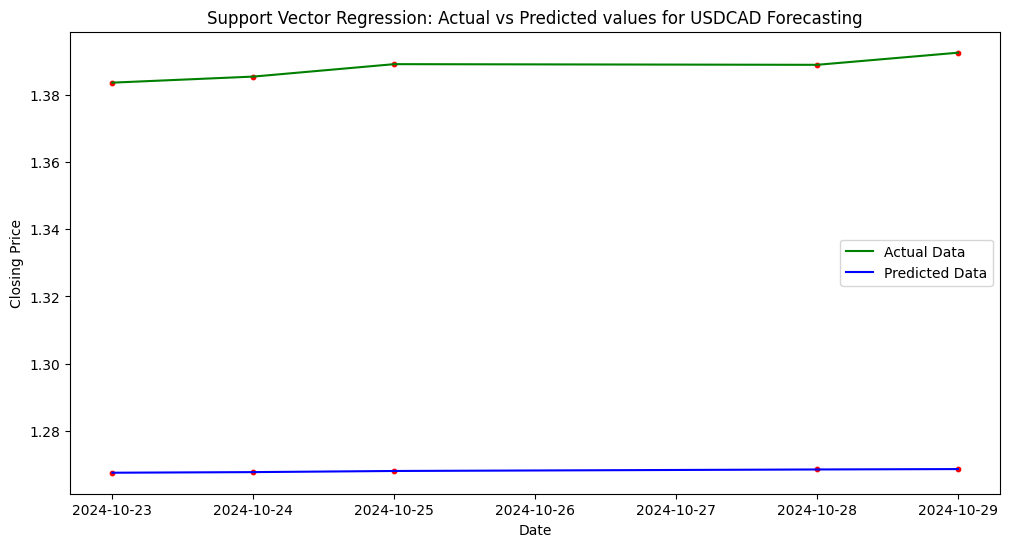

CPU times: user 167 ms, sys: 206 ms, total: 373 ms
Wall time: 135 ms


In [56]:
%%time
# Make predictions on the testing set
y_pred = svr_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
SVR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'SVR'
ModelName = 'Support Vector Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del svr_model, y_pred, future_predictions

#### Bayesian Ridge Regression Model

In [57]:
from sklearn.linear_model import BayesianRidge

In [58]:
Baye_model = BayesianRidge()
Baye_model.fit(X_train, y_train)

BayesianRidge()

In [59]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(Baye_model)

R² error on Training Data: 1.00000
R² error on Test Data: 1.00000
Excellent Model!
R² error on Training Data equals R² error on Test Data.


Mean Absolute Error: 0.00000
Mean Squared Error: 0.00000
Root Mean Squared Error: 0.00000
R-squared (R2) score: 1.00000
Future Predictions [1.3836 1.3854 1.3891 1.3889 1.3925]


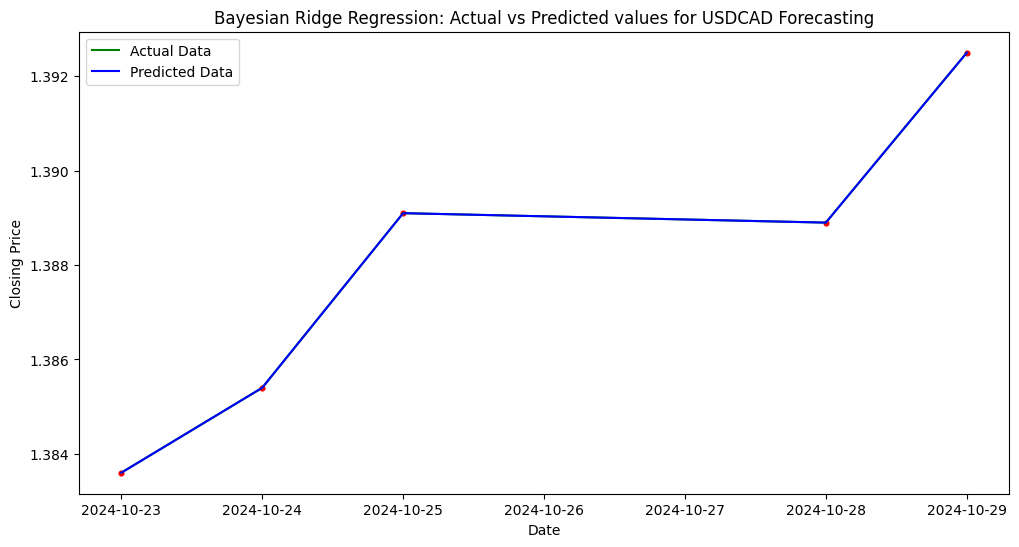

CPU times: user 278 ms, sys: 1.02 s, total: 1.3 s
Wall time: 175 ms


In [60]:
%%time
# Make predictions on the testing set
y_pred = Baye_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
BRR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'BRR'
ModelName = 'Bayesian Ridge Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del Baye_model, y_pred, future_predictions

#### AdaBoost Regression Model

In [61]:
from sklearn.ensemble import AdaBoostRegressor

In [62]:
AdaB_model = AdaBoostRegressor(n_estimators=100, random_state=None)
AdaB_model.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=100)

In [63]:
# Checking how good this Model will be
R2_Train, R2_Test, Comment = TestTheModel(AdaB_model)

R² error on Training Data: 0.99624
R² error on Test Data: 0.94790
Fairly Good Model.
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.00830
Mean Squared Error: 0.00010
Root Mean Squared Error: 0.00988
R-squared (R2) score: 0.94790
Future Predictions [1.38374578 1.38374578 1.38852076 1.38852076 1.38852076]


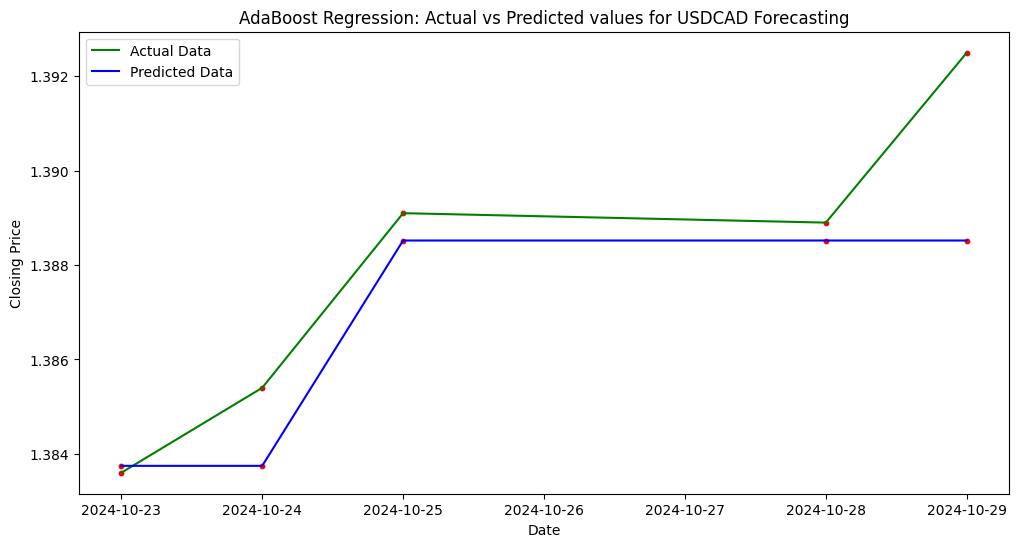

CPU times: user 165 ms, sys: 216 ms, total: 380 ms
Wall time: 142 ms


In [64]:
%%time
# Make predictions on the testing set
y_pred = AdaB_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]
ABR = future_predictions

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'ABR'
ModelName = 'AdaBoost Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, R2_Train, R2_Test, Comment, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del AdaB_model, y_pred, future_predictions

## Summary of the model results

In [65]:
Models_Compare

,ModelName,ModelCode,MAE,MSE,RMSE,R2_Train,R2_Test,Comment
0,Linear Regression,LNR,1.181117e-16,2.628546e-32,1.621279e-16,1.000000,1.000000,Excellent Model!
1,Random Forest Regressor,RFR,4.241024e-05,4.236023e-09,6.508474e-05,1.000000,0.999998,Very Good Model!
2,XGBoost Regression,XGB,5.390796e-04,4.980540e-07,7.057294e-04,0.999983,0.999734,Very Good Model!
3,Ridge Regression,RIR,3.258743e-04,1.747235e-07,4.179994e-04,0.999994,0.999907,Very Good Model!
4,Lasso Regression,LAR,6.108029e-02,5.030011e-03,7.092257e-02,0.000000,-1.685182,Bad Model.
5,Support Vector Regression,SVR,6.078970e-02,4.638540e-03,6.810683e-02,0.687184,-1.476202,Bad Model.
6,Bayesian Ridge Regression,BRR,3.236518e-11,1.680238e-21,4.099071e-11,1.000000,1.000000,Excellent Model!
7,AdaBoost Regression,ABR,8.297004e-03,9.758963e-05,9.878746e-03,0.996242,0.947904,Fairly Good Model.


In [66]:
Models_Compare[['ModelName','MAE','MSE','RMSE','R2_Train','R2_Test', 'Comment']]

,ModelName,MAE,MSE,RMSE,R2_Train,R2_Test,Comment
0,Linear Regression,1.181117e-16,2.628546e-32,1.621279e-16,1.000000,1.000000,Excellent Model!
1,Random Forest Regressor,4.241024e-05,4.236023e-09,6.508474e-05,1.000000,0.999998,Very Good Model!
2,XGBoost Regression,5.390796e-04,4.980540e-07,7.057294e-04,0.999983,0.999734,Very Good Model!
3,Ridge Regression,3.258743e-04,1.747235e-07,4.179994e-04,0.999994,0.999907,Very Good Model!
4,Lasso Regression,6.108029e-02,5.030011e-03,7.092257e-02,0.000000,-1.685182,Bad Model.
5,Support Vector Regression,6.078970e-02,4.638540e-03,6.810683e-02,0.687184,-1.476202,Bad Model.
6,Bayesian Ridge Regression,3.236518e-11,1.680238e-21,4.099071e-11,1.000000,1.000000,Excellent Model!
7,AdaBoost Regression,8.297004e-03,9.758963e-05,9.878746e-03,0.996242,0.947904,Fairly Good Model.


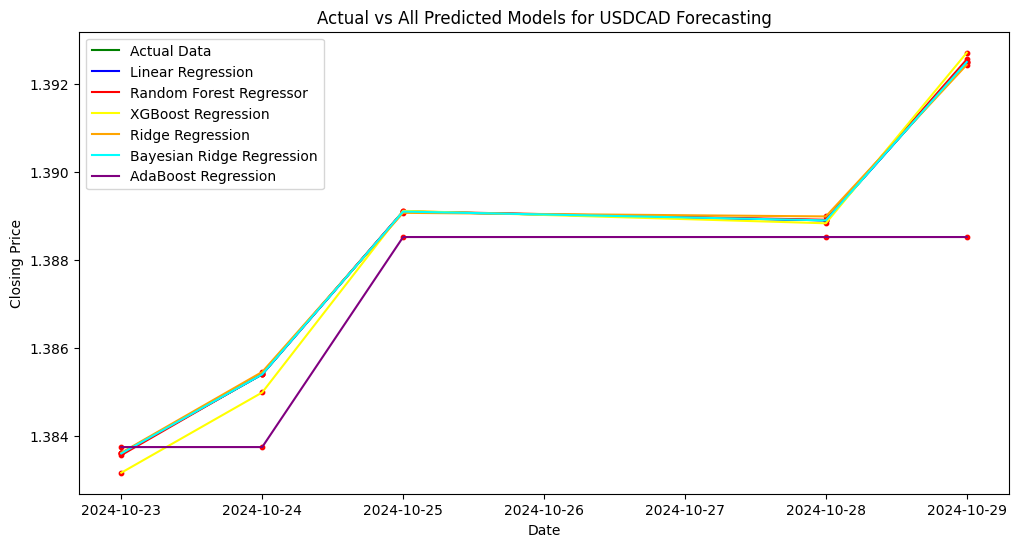

In [67]:
# Plotting the graph
Future_Dates = pd.date_range(start=MaxDate+timedelta(days=1), periods=PredDays, freq="B")

# Plot Actual vs Predicted prices
plt.figure(figsize=(12, 6))
plt.plot(Future_Dates, ActualValues, label='Actual Data', color='green')
plt.plot(Future_Dates, LNR, label='Linear Regression', color='blue')
plt.plot(Future_Dates, RFR, label='Random Forest Regressor', color='red')
plt.plot(Future_Dates, XGB, label='XGBoost Regression', color='yellow')
plt.plot(Future_Dates, RIR, label='Ridge Regression', color='orange')
#plt.plot(Future_Dates, LAR, label='Lasso Regression', color='black')
#plt.plot(Future_Dates, SVR, label='Support Vector Regression', color='magenta')
plt.plot(Future_Dates, BRR, label='Bayesian Ridge Regression', color='cyan')
plt.plot(Future_Dates, ABR, label='AdaBoost Regression', color='purple')
plt.scatter(Future_Dates, ActualValues, s=10, color='red')
plt.scatter(Future_Dates, LNR, s=10, color='red')
plt.scatter(Future_Dates, RFR, s=10, color='red')
plt.scatter(Future_Dates, XGB, s=10, color='red')
plt.scatter(Future_Dates, RIR, s=10, color='red')
#plt.scatter(Future_Dates, LAR, s=10, color='red')
#plt.scatter(Future_Dates, SVR, s=10, color='red')
plt.scatter(Future_Dates, BRR, s=10, color='red')
plt.scatter(Future_Dates, ABR, s=10, color='red')
plt.title('Actual vs All Predicted Models for ' + CrncyPair + ' Forecasting')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [68]:
# Free the Memory
#del FxPair_Data, X, y, X_train, X_test, y_train, y_test